# Analyse du facteur de charge éolien à Toulouse entre 1980 et 2022

### Chargement des packages et choix des options

In [2]:
#importation des packages

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import random
import pyarrow
import statsmodels.api as sm

In [3]:
#Choix des options

#Lien pour les données
#data_path=""
#data_path="Données/"
data_path="Données/"

## Mise en forme des données

On a des téléchargé les données de facteur de charge à Toulouse pour un certain modèle d'éolienne (voir Info_données dans le dossier data/Toulouse/Wind_power_default) sous forme de 43 fichiers CSV (1 par an). L'idée est de combiner toute es données pour obtenir un fichier csv avec les données horaires et un fichier avec les données journalières pour la suite de l'étude.
On fait le choix de créer se programme en dehors dans le fichier 'utility_tools' pour pouvoir le réutiliser par la suite.

In [4]:
from utility_tools import regroupement_data

data_hour_wind,data_day_wind=regroupement_data(data_path+'Data_Toulouse/Wind_power_default/',1980,2022)

print(data_hour_wind.head(),data_hour_wind.tail(),data_day_wind.head(),data_day_wind.tail())
#print(data_day_wind.dtypes)

Toutes les données sont différentes
                 time        local_time  electricity  wind_speed
0 1980-01-01 00:00:00  1980-01-01 01:00        0.132       5.062
1 1980-01-01 01:00:00  1980-01-01 02:00        0.108       4.756
2 1980-01-01 02:00:00  1980-01-01 03:00        0.107       4.753
3 1980-01-01 03:00:00  1980-01-01 04:00        0.086       4.448
4 1980-01-01 04:00:00  1980-01-01 05:00        0.085       4.439                     time        local_time  electricity  wind_speed
8755 2022-12-31 19:00:00  2022-12-31 20:00        0.429       7.650
8756 2022-12-31 20:00:00  2022-12-31 21:00        0.422       7.603
8757 2022-12-31 21:00:00  2022-12-31 22:00        0.420       7.593
8758 2022-12-31 22:00:00  2022-12-31 23:00        0.426       7.632
8759 2022-12-31 23:00:00  2023-01-01 00:00        0.423       7.613             electricity  wind_speed
time                               
1980-01-01     0.274292    6.263542
1980-01-02     0.334875    6.864042
1980-01-03     0.02370

On va maintenant afficher les données journalières et horaires

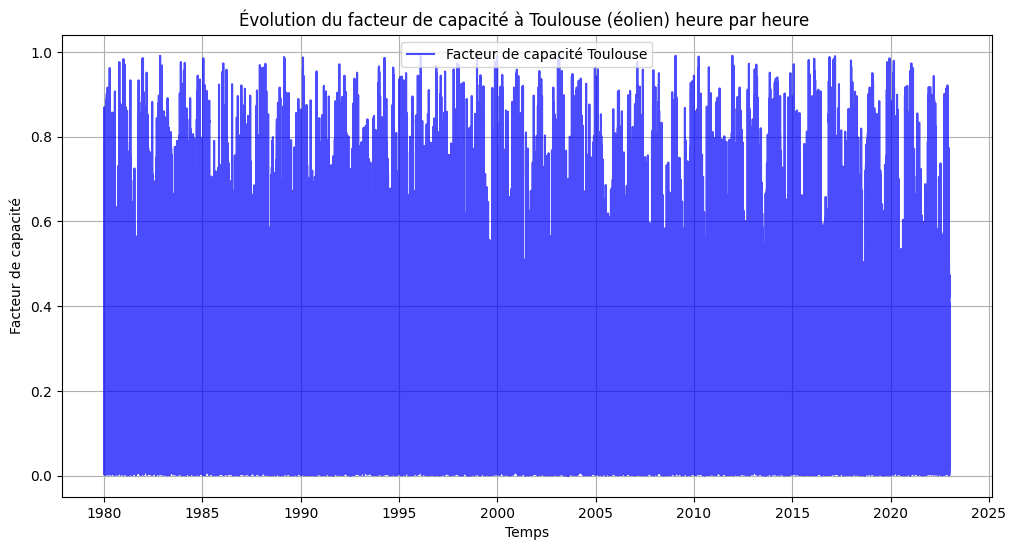

In [5]:
# Création du graphique de série temporelle pour la capacité
plt.figure(figsize=(12, 6))
plt.plot(data_hour_wind['time'], data_hour_wind['electricity'], label='Facteur de capacité Toulouse', color='blue', alpha=0.7)
plt.title('Évolution du facteur de capacité à Toulouse (éolien) heure par heure ')
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.legend()
plt.grid(True)
plt.show()


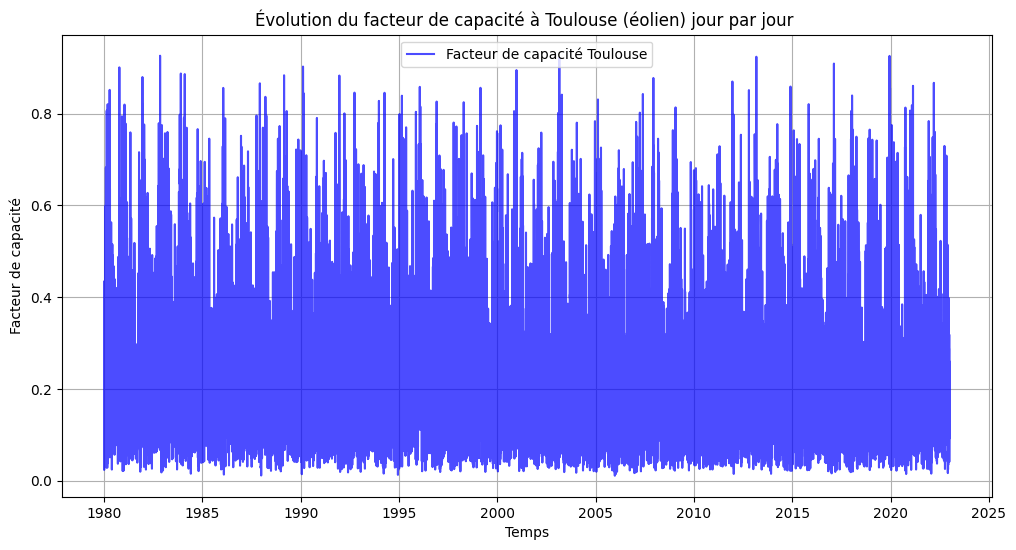

In [6]:
# Création du graphique de série temporelle pour la capacité
plt.figure(figsize=(12, 6))
plt.plot(data_day_wind.index, data_day_wind['electricity'], label='Facteur de capacité Toulouse', color='blue', alpha=0.7)
plt.title('Évolution du facteur de capacité à Toulouse (éolien) jour par jour ')
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.legend()
plt.grid(True)
plt.show()

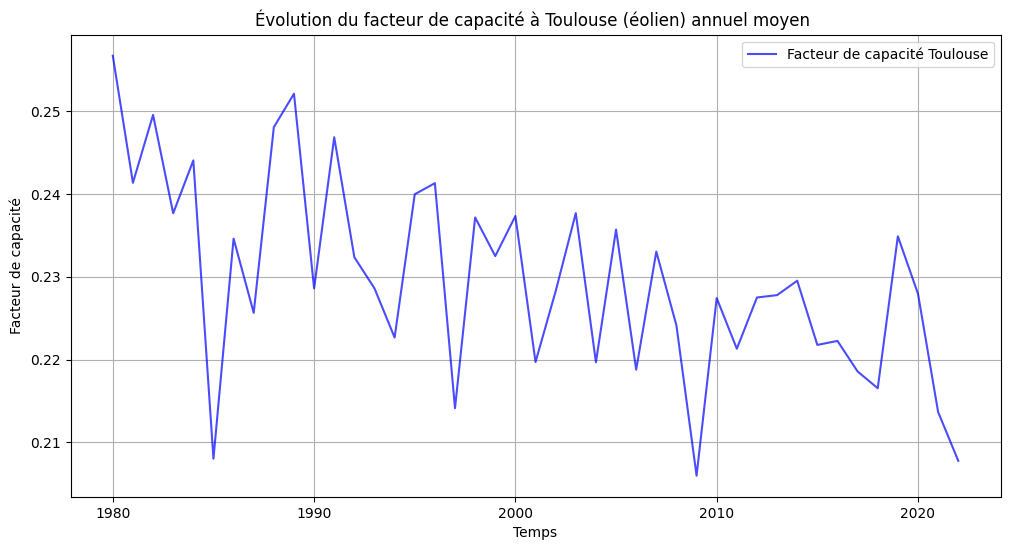

In [7]:
# On commence par regrouper les données par année

data_year_wind = data_hour_wind.groupby(data_hour_wind['time'].dt.year).agg({'electricity': 'mean', 'wind_speed': 'mean'})

# Création du graphique de série temporelle pour la capacité nationale
plt.figure(figsize=(12, 6))
plt.plot(data_year_wind.index, data_year_wind['electricity'], label='Facteur de capacité Toulouse', color='blue', alpha=0.7)
plt.title('Évolution du facteur de capacité à Toulouse (éolien) annuel moyen ')
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.legend()
plt.grid(True)
plt.show()

## Etude de tendance et saisonnalité

### Etude de la tendance

On va maintenant étudier la tendance de nos données.

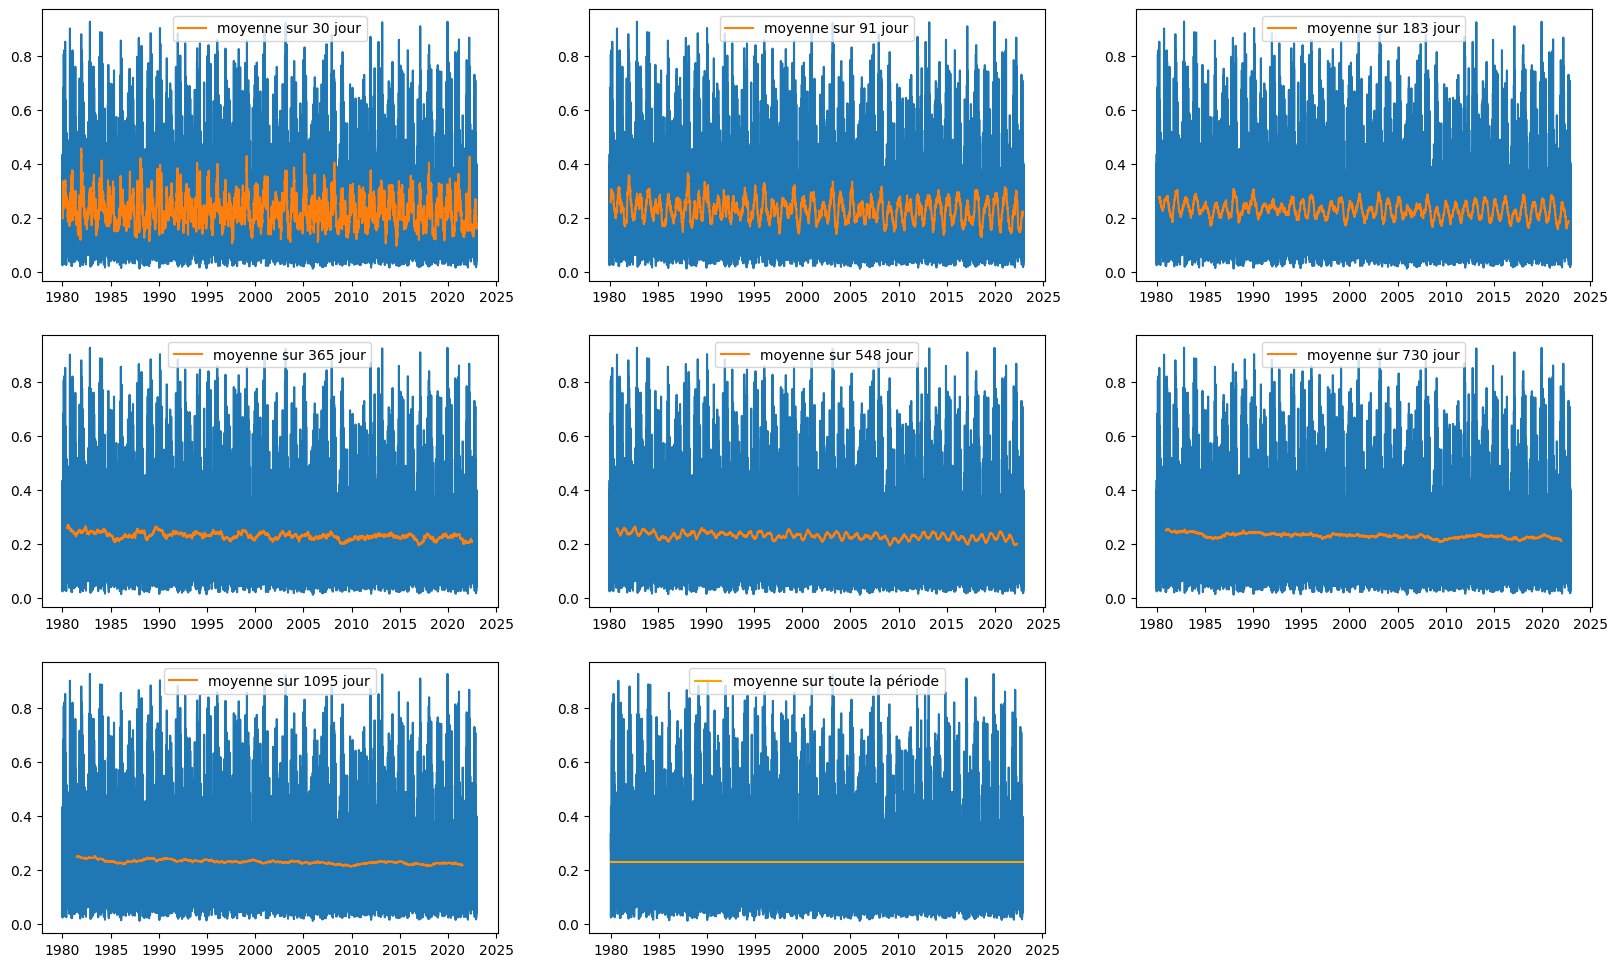

In [8]:
win = [30, 91, 183, 365, 548, 730, 1095] # fenêtre d'observation (en nombre de semaines)
fig = plt.figure(figsize=(20,12))

for i in range(len(win)):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(data_day_wind['electricity'])
    ax.plot(data_day_wind['electricity'].rolling(win[i], center=True).mean(), label=f"moyenne sur {win[i]} jour")
    ax.legend()
    
ax = fig.add_subplot(3, 3, 8)
ax.plot(data_day_wind['electricity'])
ax.hlines(data_day_wind['electricity'].mean(), xmin=3600,xmax=19400,label=f"moyenne sur toute la période",color='orange')
ax.legend()

On observe la tendance sur 1 mois, 3 mois, 6 mois, 1 an, 1 an et demi, 2 ans et 3 ans. On observe que quand la durée de la fenêtre augmente, la tendance approche de plus en plus d'une fonction constante : la tendance du facteur de charge éolien est donc plutôt constant. On observe également une tendance plus linéaire sur des multiples d'un an, ce qui confirme l'intuition qu'on a une saisonnalitée sur 1 an.
Cette analyse est cohérente avec nos intuitions : la tendance du vent n'évolue pas ou très peu au cours du temps.

### Etude de la saisonnalité

On va maintenant étudier la saisonnalité de nos données.

month  day
12     26     0.283665
       27     0.279244
       28     0.293127
       29     0.241680
       30     0.250356
       31     0.219791
1      1      0.247641
       2      0.296374
       3      0.242205
       4      0.246486
       5      0.234464
       6      0.252540
       7      0.231088
       8      0.233096
       9      0.207310
       10     0.231466
       11     0.242706
       12     0.228578
       13     0.263130
       14     0.271376
Name: electricity, dtype: float64
[0.23323865 0.23239784 0.23391071 0.23966611 0.24677865 0.25850069
 0.26240919 0.26298436 0.26489161 0.26139673 0.26214106 0.26235507
 0.26346595]


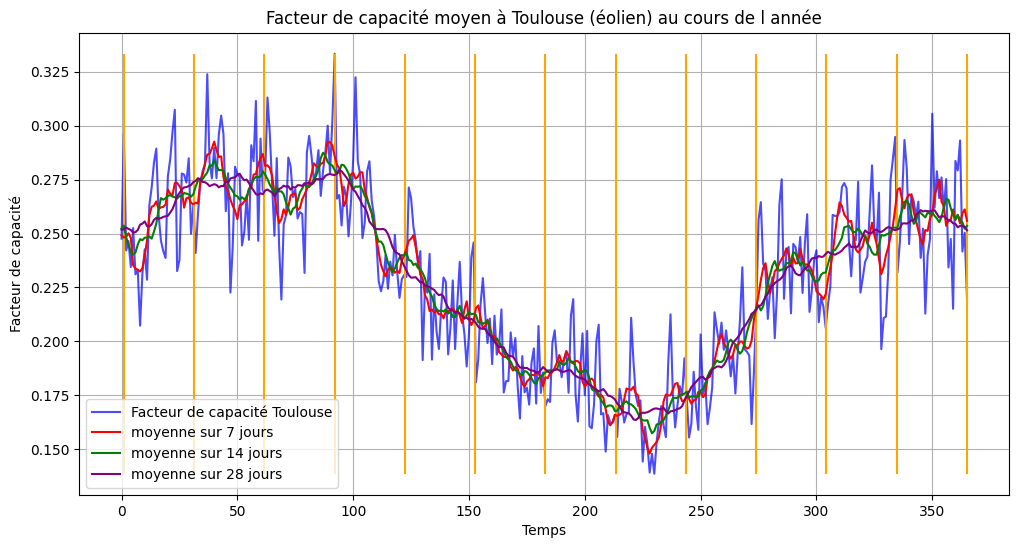

In [9]:
# On commence par regrouper les données par année
data_hour_copy=data_hour_wind.copy()
data_hour_copy['day']=data_hour_copy['time'].dt.day
data_hour_copy['month']=data_hour_copy['time'].dt.month

data_year_wind_tendance = data_hour_copy.groupby(['month', 'day']).agg({'electricity': 'mean', 'wind_speed': 'mean'})

#print(type(data_year_wind_tendance.index))



# Création du graphique de série temporelle pour la capacité nationale
plt.figure(figsize=(12, 6))
plt.plot(np.arange(366),data_year_wind_tendance['electricity'], label='Facteur de capacité Toulouse', color='blue', alpha=0.7)
plt.title('Facteur de capacité moyen à Toulouse (éolien) au cours de l année')
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.grid(True)

time_tick  = np.linspace(1, 365, 13)
plt.vlines(x = time_tick, ymin = data_year_wind_tendance['electricity'].min(), ymax = data_year_wind_tendance['electricity'].max(), colors = "orange")

print(pd.concat([data_year_wind_tendance['electricity'][360:],data_year_wind_tendance['electricity']])[:20])
print(data_year_wind_tendance['electricity'].rolling(7, center=True).mean().to_numpy()[:20][7:])

#On ajoute une "moyenne" en lissant
#On ajoute également des données avant et après pour avoir une moyenne lissée sur toute l'année

plt.plot(pd.concat([data_year_wind_tendance['electricity'][359:],data_year_wind_tendance['electricity'],data_year_wind_tendance['electricity'][:7]]).rolling(7, center=True).mean().to_numpy()[7:373], label=f"moyenne sur 7 jours", color = "red")
plt.plot(pd.concat([data_year_wind_tendance['electricity'][352:],data_year_wind_tendance['electricity'],data_year_wind_tendance['electricity'][:14]]).rolling(14, center=True).mean().to_numpy()[14:380], label=f"moyenne sur 14 jours", color = "green")
plt.plot(pd.concat([data_year_wind_tendance['electricity'][338:],data_year_wind_tendance['electricity'],data_year_wind_tendance['electricity'][:28]]).rolling(28, center=True).mean().to_numpy()[28:394], label=f"moyenne sur 28 jours", color = "purple")
plt.legend()

saison28=pd.concat([data_year_wind_tendance['electricity'][338:],data_year_wind_tendance['electricity'],data_year_wind_tendance['electricity'][:28]]).rolling(28, center=True).mean().to_numpy()[28:394]

plt.show()

Interprétation : à faire

### Etude avec la fonction "decompose"

On va maintenant étudier les données avec la fonction "decompose". Comment elle marche ?

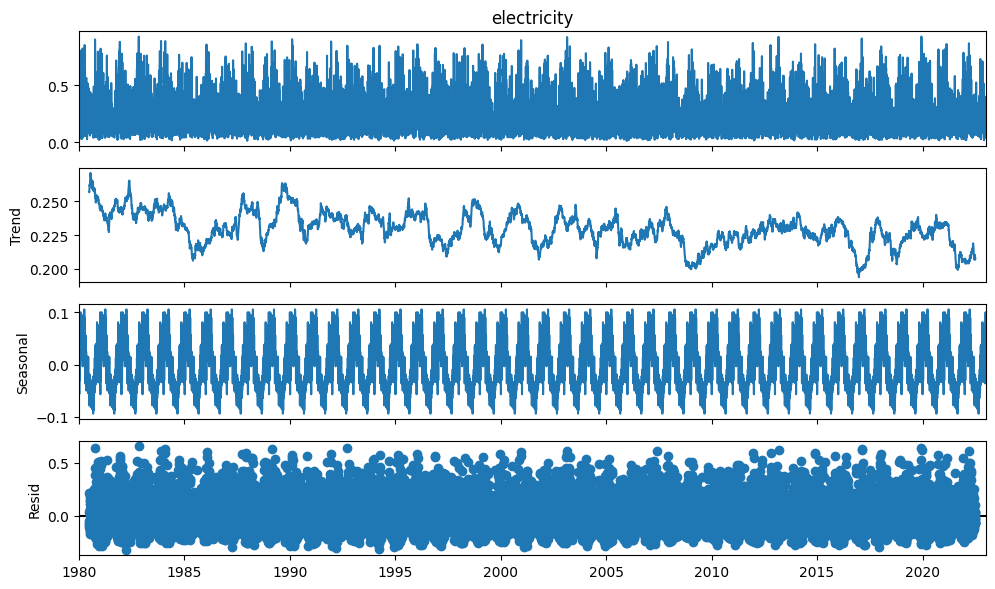

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

decomp = seasonal_decompose(data_day_wind['electricity'], model='additive',period=365)

fig = decomp.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

## Modèle ARMA

In [11]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



On va mettre en place un modèle ARMA a partir de la moyenne sur les 42 années de données observées. On commence oar étudier si cette série temporelle peut être modélisée par un modèle ARMA : 

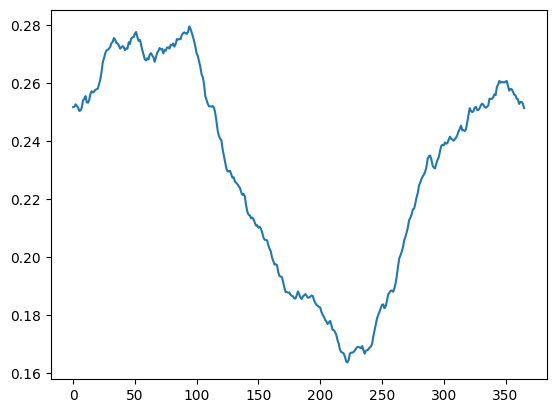

In [12]:
serie = (pd.concat([data_year_wind_tendance['electricity'][338:],data_year_wind_tendance['electricity'],data_year_wind_tendance['electricity'][:28]]).rolling(28, center=True).mean().to_numpy()[28:394])
plt.plot(serie)

### Etude de la faisabilité de la modélisation

In [13]:
_, p, _, _, _, _ = adfuller(serie)
print("La p-value est de: ", round(p, 3))

La p-value est de:  0.147


Ce bout de code permet de récupérer la p-value du test de Dickey-Fuller de la série. Ce score indique si la série peut être considérée comme stationnaire. En général, s’il est inférieur à 0.05, on la considère stationnaire. Ici, la p-valeur permet d'affirmer que la série est stationnaire. 

### Modélisation ARMA

On passe désormais à la modélisation de la série temporelle, qui va passer par la création d’un modèle ARMA dont il faudra ajuster les paramètres afin de correspondre le mieux possible à la série temporelle concernée.

Ici, les termes p et q correspondent respectivement au premier et au dernier chiffres de l’argument order de la fonction. La méthode fit ajoutée à la fin sert à entraîner le modèle pour qu’il détermine seul ses paramètres. 

La méthode summary permet de vérifier que notre modèle est bon, elle affiche :

In [14]:
arma = ARIMA(serie, order=(1,0,3)).fit()

arma.summary()

c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:                 ARIMA(1, 0, 3)   Log Likelihood                2001.948
Date:                Mon, 18 Mar 2024   AIC                          -3991.897
Time:                        16:03:20   BIC                          -3968.481
Sample:                             0   HQIC                         -3982.592
                                - 366                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2298      0.045      5.144      0.000       0.142       0.317
ar.L1          0.9985      0.003    383.147      0.000       0.993       1.004
ma.L1          0.4921      0.053      9.349      0.000       0.389       0.595
ma.L2          0.2939      0.059      4.946      0.000       0.177       0.410
ma.L3          0.1106      0.053      2.089      0.037       0.007       0.214
sigma2      1.008e-06   7.69e-08     13.119      0.000    8.58e-07    1.16e-06
===================================================================================
Ljung-Box (L1) (Q):                   2.72   Jarque-Bera (JB):                 0.39
Prob(Q):                              0.10   Prob(JB):                         0.82
Heteroskedasticity (H):               0.83   Skew:                            -0.06
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

La colonne colonne "coef" correspond aux paramètres du modèle et la colonne "P>|z|" donne la p-value de chacun des paramètres. Ici on voit que les paramètres sont bons car la p-value est toujours inférieure à 0,05. Si ce n’est pas le cas, on peut modifier p et q pour supprimer les paramètres inutiles.

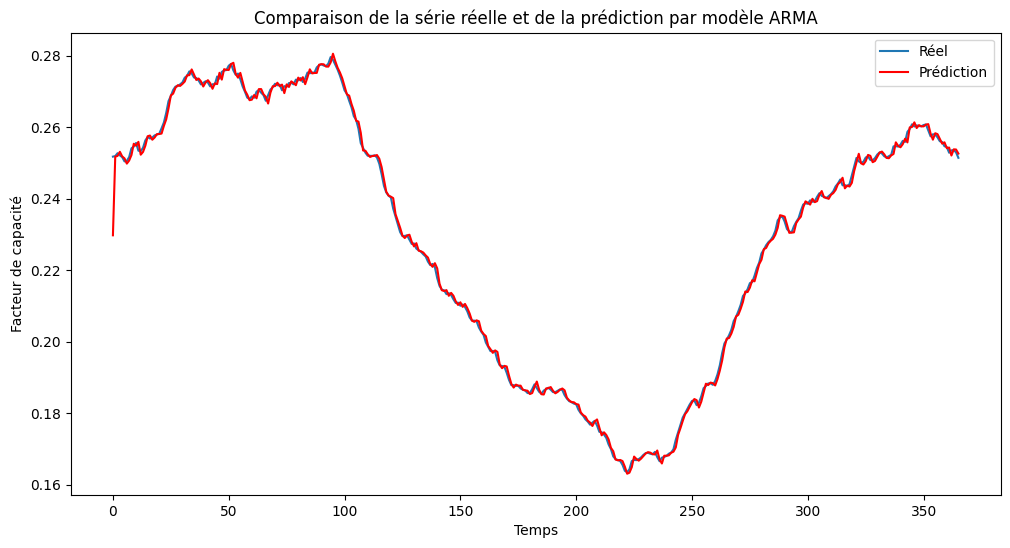

In [15]:
pred = arma.predict()

plt.figure(figsize=(12,6))
plt.plot(serie,label="Réel")
plt.plot(pred, color = "r",label="Prédiction")
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA")
plt.legend()
plt.show()

On a ainsi en rouge notre modèle et en bleu les valeurs réelles.

### ARMA avec des meilleures données

On va maintenant essayer d'appliquer la méthode Arma sur nos données journalières, auquels on a soustrait la tendance et la saisonnalité.
Pour l'instant, on va considérer la tendance comme moyenne et la saisonnalité comme la moyenne lissée sur 28 jours.

C:\Users\Manon Julia\AppData\Local\Temp\ipykernel_34552\1516404596.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_day_season['electricity'][int(0.75+i*365.25):int(0.75+(i+1)*365.25)]=data_day_season['electricity'][int(0.75+i*365.2

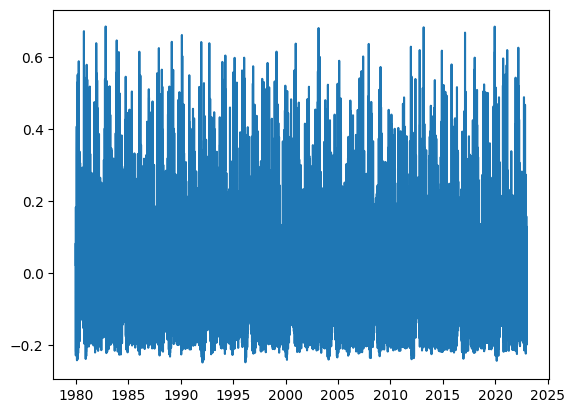

In [16]:
#Mise en forme des données

#Etant donné qu'on a pas soustrait la tendance pour calculer la saisonnalité jusqu'à maintenant, car on prend une tendance constante, je vais juste retirer la saisonnalité.


#On initialise les données
data_day_season=data_day_wind.copy()
bissextile=4

for i in range(43): #On parcourt nos 43 années de données
    
    if bissextile == 4 : #Si année bissextile
        tend=saison28
        bissextile=0
    else:
        tend=saison28[~59]
        
    #print(1980+i,int(0.75+i*365.25),int(0.75+(i+1)*365.25))
    data_day_season['electricity'][int(0.75+i*365.25):int(0.75+(i+1)*365.25)]=data_day_season['electricity'][int(0.75+i*365.25):int(0.75+(i+1)*365.25)]-tend
    
    bissextile += 1

    
plt.plot(data_day_season['electricity'])


In [17]:
serie_ = data_day_season['electricity']

_, p, _, _, _, _ = adfuller(serie_)
print("La p-value est de: ", round(p, 3))

La p-value est de:  0.0


In [18]:
result = adfuller(serie_)
print('Statistique ADF : %f' % result[0])
print('p-value : %f' % result[1])

Statistique ADF : -24.193211
p-value : 0.000000


### Etude des paramètres

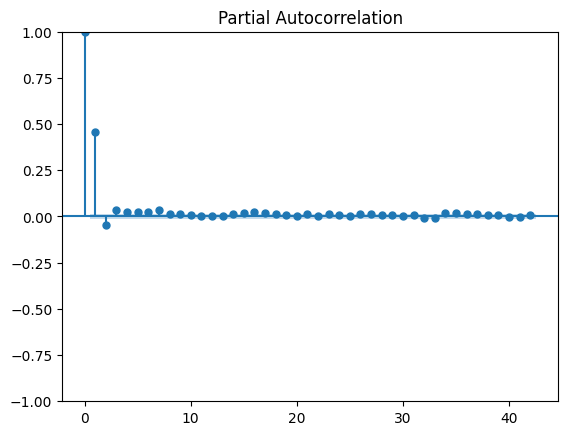

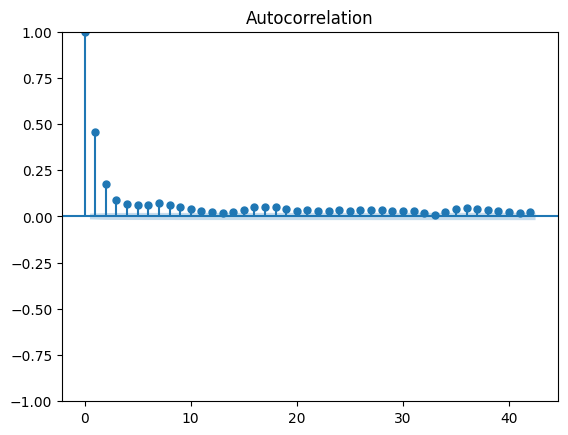

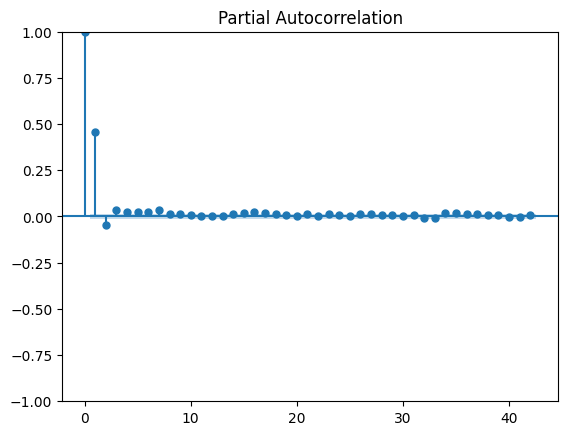

In [19]:
plot_acf(serie_)
plot_pacf(serie_)

### Modèle ARMA V1

In [20]:
# On utilise les graphes ci-dessus pour déterminer les valeurs de p et q
p = 8
q = 11
d = 0 
arma = ARIMA(serie_, order=(p,d,q)).fit()

arma.summary()

c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            electricity   No. Observations:                15706
Model:                ARIMA(8, 0, 11)   Log Likelihood                8603.569
Date:                Mon, 18 Mar 2024   AIC                         -17165.138
Time:                        16:04:41   BIC                         -17004.240
Sample:                    01-01-1980   HQIC                        -17111.874
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0083      0.004     -2.037      0.042      -0.016      -0.000
ar.L1          0.8265      8.271      0.100      0.920     -15.384      17.037
ar.L2          0.2172     10.300      0.021      0.983     -19.971      20.405
ar.L3         -0.2150      2.322     -0.093      0.926      -4.767       4.337
ar.L4         -0.3260      2.461     -0.132      0.895      -5.149       4.497
ar.L5          0.1989      2.992      0.066      0.947      -5.665       6.063
ar.L6         -0.1158      3.914     -0.030      0.976      -7.788       7.556
ar.L7          0.2338      2.491      0.094      0.925      -4.648       5.115
ar.L8          0.1121      2.333      0.048      0.962      -4.460       4.684
ma.L1         -0.3552      8.270     -0.043      0.966     -16.565      15.855
ma.L2         -0.4486      6.449     -0.070      0.945     -13.089      12.192
ma.L3          0.0502      2.380      0.021      0.983      -4.615       4.715
ma.L4          0.3776      2.130      0.177      0.859      -3.797       4.552
ma.L5         -0.0274      3.603     -0.008      0.994      -7.089       7.034
ma.L6          0.0794      2.478      0.032      0.974      -4.778       4.936
ma.L7         -0.1643      1.201     -0.137      0.891      -2.519       2.191
ma.L8         -0.1968      1.434     -0.137      0.891      -3.007       2.613
ma.L9         -0.0795      0.872     -0.091      0.927      -1.789       1.630
ma.L10        -0.0292      0.272     -0.107      0.915      -0.563       0.504
ma.L11        -0.0087      0.123     -0.071      0.944      -0.249       0.232
sigma2         0.0196      0.000     91.610      0.000       0.019       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2749.00
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.89
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

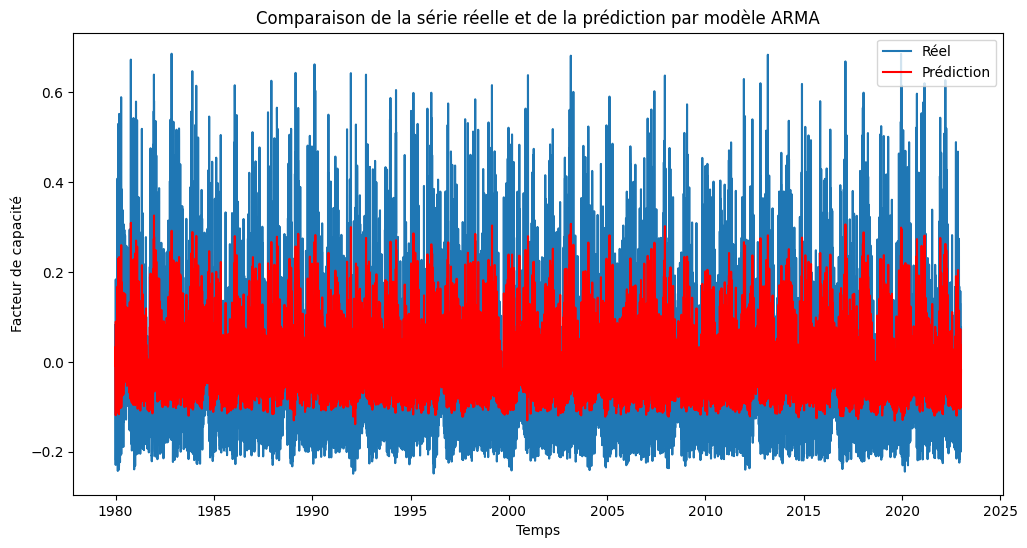

In [21]:
pred = arma.predict()

plt.figure(figsize=(12,6))
plt.plot(serie_,label="Réel")
plt.plot(pred, color = "r",label="Prédiction")
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA")
plt.legend()
plt.show()


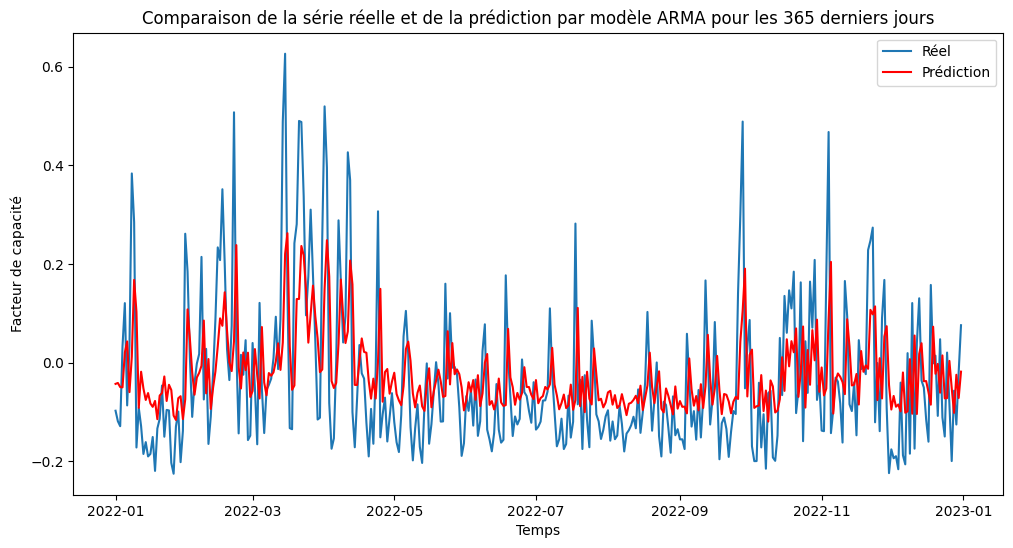

In [22]:
# Sélection des 365 derniers jours pour chaque série
serie_derniere_annee = serie_[-365:]
pred_derniere_annee = pred[-365:]

# Création du graphique
plt.figure(figsize=(12,6))

# Affichage de la série réelle pour les 365 derniers jours
plt.plot(serie_derniere_annee, label="Réel")

# Affichage de la prédiction pour les 365 derniers jours
plt.plot(pred_derniere_annee, color = "r", label="Prédiction")

# Ajout des légendes et titres
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA pour les 365 derniers jours")
plt.legend()

# Affichage du graphique
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [24]:
# Calcul du MSE
mse = mean_squared_error(serie_derniere_annee, pred_derniere_annee)

# Calcul du MAE
mae = mean_absolute_error(serie_derniere_annee, pred_derniere_annee)

# Calcul du RMSE
rmse = np.sqrt(mse)

# Calcul du R^2
r2 = r2_score(serie_derniere_annee, pred_derniere_annee)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MSE: 0.017252496811640886
MAE: 0.10162093671434456
RMSE: 0.13134876022117942
R²: 0.26589202879279494


### Modèle ARMA V2

In [25]:
arma = ARIMA(serie_, order=(1,0,3)).fit()

arma.summary()

c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            electricity   No. Observations:                15706
Model:                 ARIMA(1, 0, 3)   Log Likelihood                8587.351
Date:                Mon, 18 Mar 2024   AIC                         -17162.701
Time:                        16:04:55   BIC                         -17116.730
Sample:                    01-01-1980   HQIC                        -17147.483
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0083      0.004     -2.094      0.036      -0.016      -0.001
ar.L1          0.9646      0.007    132.194      0.000       0.950       0.979
ma.L1         -0.4949      0.010    -48.381      0.000      -0.515      -0.475
ma.L2         -0.3050      0.009    -35.629      0.000      -0.322      -0.288
ma.L3         -0.1002      0.008    -12.987      0.000      -0.115      -0.085
sigma2         0.0196      0.000     91.537      0.000       0.019       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              2772.02
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.90
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

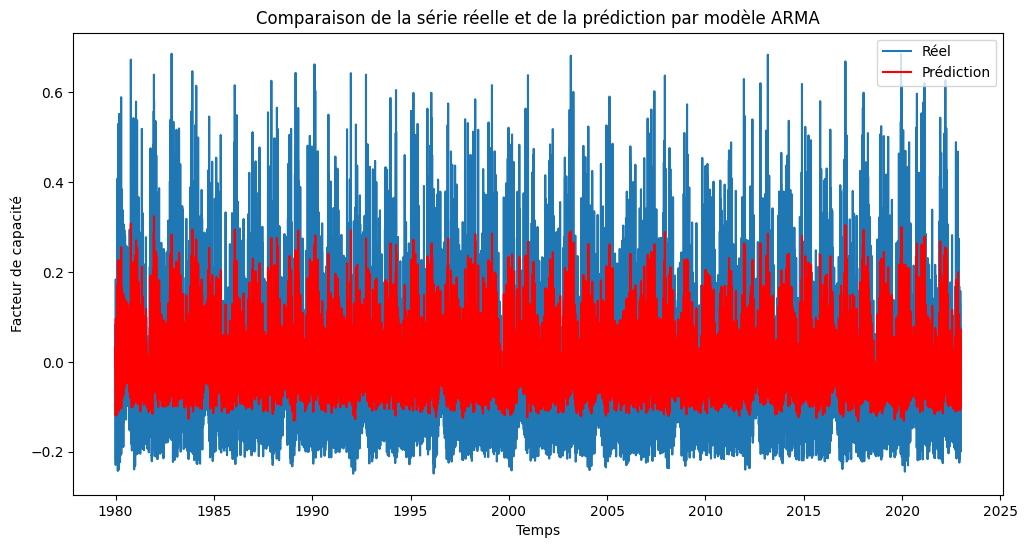

In [26]:
pred = arma.predict()

plt.figure(figsize=(12,6))
plt.plot(serie_,label="Réel")
plt.plot(pred, color = "r",label="Prédiction")
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA")
plt.legend()
plt.show()

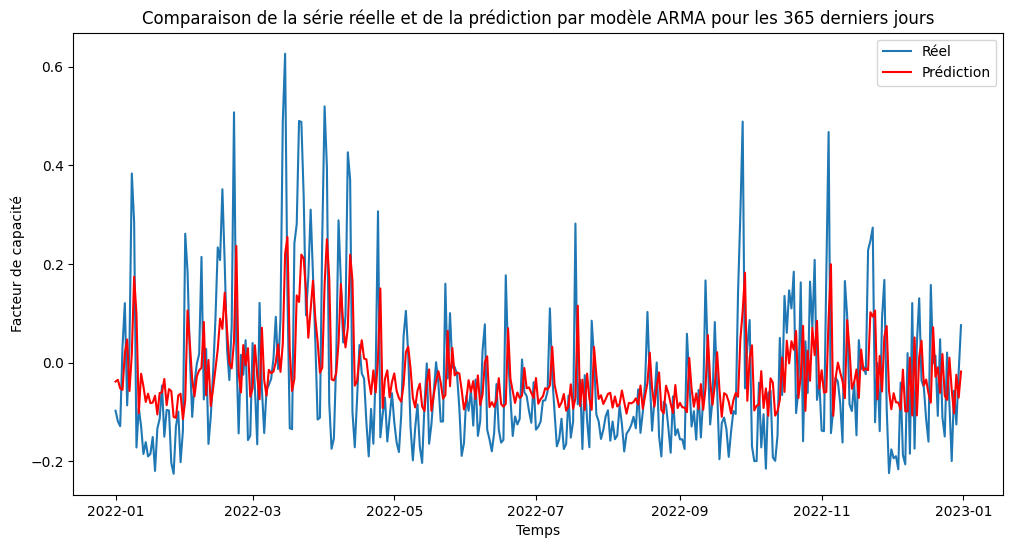

In [27]:
# Sélection des 365 derniers jours pour chaque série
serie_derniere_annee = serie_[-365:]
pred_derniere_annee = pred[-365:]

# Création du graphique
plt.figure(figsize=(12,6))

# Affichage de la série réelle pour les 365 derniers jours
plt.plot(serie_derniere_annee, label="Réel")

# Affichage de la prédiction pour les 365 derniers jours
plt.plot(pred_derniere_annee, color = "r", label="Prédiction")

# Ajout des légendes et titres
plt.xlabel('Temps')
plt.ylabel('Facteur de capacité')
plt.title("Comparaison de la série réelle et de la prédiction par modèle ARMA pour les 365 derniers jours")
plt.legend()

# Affichage du graphique
plt.show()


### Evaluation de la performance du modèle

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcul du MSE
mse = mean_squared_error(serie_derniere_annee, pred_derniere_annee)

# Calcul du MAE
mae = mean_absolute_error(serie_derniere_annee, pred_derniere_annee)

# Calcul du RMSE
rmse = np.sqrt(mse)

# Calcul du R^2
r2 = r2_score(serie_derniere_annee, pred_derniere_annee)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MSE: 0.01718373288815149
MAE: 0.10142474638483692
RMSE: 0.13108673803307294
R²: 0.2688179904617741


* Erreur quadratique moyenne (Mean Squared Error, MSE) : elle mesure la moyenne des carrés des erreurs, c'est-à-dire, la différence moyenne entre les valeurs observées et les valeurs prédites. Plus le MSE est faible, meilleure est la prédiction.

* Erreur absolue moyenne (Mean Absolute Error, MAE) : elle mesure la moyenne des valeurs absolues des erreurs. Le MAE est plus facile à interpréter que le MSE car il est exprimé dans les mêmes unités que les données d'origine.

* Racine de l'erreur quadratique moyenne (Root Mean Squared Error, RMSE) : c'est la racine carrée du MSE. Le RMSE est utile car il donne une idée de la taille de l'erreur générée par le modèle de prédiction.

* Le coefficient de détermination (R²) : il mesure la qualité de l'ajustement d'un modèle linéaire. Pour des modèles non linéaires ou non paramétriques comme ARMA, R² peut ne pas être le meilleur indicateur de performance, mais il peut donner une indication de la proportion de la variance des données expliquée par le modèle.

# ARIMAX

Le modèle ARIMAX (AutoRegressive Integrated Moving Average with eXogenous variables) est une extension du modèle ARIMA, qui est lui-même un modèle de prédiction de séries temporelles. L'ARIMA combine trois composantes principales pour modéliser et prédire des données temporelles : l'autorégression (AR), l'intégration (I) pour rendre la série stationnaire, et les moyennes mobiles (MA). Le modèle ARIMAX y ajoute une composante supplémentaire, les variables exogènes (X), pour améliorer la précision des prédictions.

Composantes du modèle ARIMAX :

* AR (AutoRégression) : Cette partie du modèle utilise la dépendance entre une observation et un certain nombre de ses retards (observations précédentes). Si vous regardez une série temporelle, cela signifie que les valeurs futures sont prédites en fonction des valeurs passées.

* I (Intégration) : Cette composante sert à rendre la série temporelle stationnaire, c'est-à-dire à éliminer les tendances ou les saisons qui peuvent exister dans les données. Cela se fait souvent en différenciant la série, c'est-à-dire en soustrayant une observation précédente de l'observation actuelle.

* MA (Moyennes Mobiles) : Cette partie du modèle implique l'utilisation de la dépendance entre une observation et un résidu d'erreur provenant d'un modèle de moyenne mobile appliqué à des observations retardées. En d'autres termes, les valeurs futures sont prédites en se basant sur les erreurs des prédictions passées.

* X (Variables Exogènes) : C'est ce qui différencie l'ARIMAX de l'ARIMA. Les variables exogènes sont des variables externes qui peuvent influencer la variable que vous essayez de prédire mais ne sont pas influencées par elle. En incluant ces variables dans le modèle, vous pouvez potentiellement améliorer la précision de vos prédictions en tenant compte d'informations supplémentaires pertinentes.

Utilisation d'ARIMAX :

Le modèle ARIMAX est particulièrement utile lorsque vous avez des données temporelles que vous souhaitez prédire et que vous savez qu'il existe d'autres facteurs externes qui peuvent influencer ces prédictions. En intégrant ces informations externes, le modèle peut fournir des prédictions plus précises que l'ARIMA seul.

Par exemple, si vous souhaitez prédire la demande d'électricité, les températures passées (une variable exogène) pourraient être un bon prédicteur, en plus des données historiques de demande.

L'ajout de variables exogènes peut compliquer la modélisation et l'interprétation du modèle, mais avec une sélection appropriée de ces variables et un ajustement minutieux, l'ARIMAX peut être un outil puissant pour les prévisions de séries temporelles.

## Ouverture et traitement des données hexogènes

In [29]:
data_path="Données/"

In [30]:
from utility_tools import regroupement_data

df_hour_weather,df_day_weather=regroupement_data(data_path+'Data_Toulouse/Weather/',2020,2022,data_type="weather")

print(df_hour_weather.head(),df_hour_weather.tail(),df_day_weather.head(),df_day_weather.tail())
#print(data_day_wind.dtypes)

Toutes les données sont différentes
                 time        local_time    t2m  prectotland  precsnoland  \
0 2020-01-01 00:00:00  2020-01-01 01:00  5.369        0.002          0.0   
1 2020-01-01 01:00:00  2020-01-01 02:00  5.392        0.002          0.0   
2 2020-01-01 02:00:00  2020-01-01 03:00  5.338        0.002          0.0   
3 2020-01-01 03:00:00  2020-01-01 04:00  5.179        0.002          0.0   
4 2020-01-01 04:00:00  2020-01-01 05:00  5.185        0.002          0.0   

   snomas   rhoa  swgdn  swtdn  cldtot  
0     0.0  1.250    0.0    0.0   0.967  
1     0.0  1.250    0.0    0.0   0.930  
2     0.0  1.251    0.0    0.0   0.837  
3     0.0  1.251    0.0    0.0   0.758  
4     0.0  1.251    0.0    0.0   0.731                       time        local_time    t2m  prectotland  precsnoland  \
8755 2022-12-31 19:00:00  2022-12-31 20:00  9.939        0.003          0.0   
8756 2022-12-31 20:00:00  2022-12-31 21:00  9.256        0.003          0.0   
8757 2022-12-31 21:00:00

In [31]:
df_hour_weather.head()

,time,local_time,t2m,prectotland,precsnoland,snomas,rhoa,swgdn,swtdn,cldtot
0,2020-01-01 00:00:00,2020-01-01 01:00,5.369,0.002,0.0,0.0,1.250,0.0,0.0,0.967
1,2020-01-01 01:00:00,2020-01-01 02:00,5.392,0.002,0.0,0.0,1.250,0.0,0.0,0.930
2,2020-01-01 02:00:00,2020-01-01 03:00,5.338,0.002,0.0,0.0,1.251,0.0,0.0,0.837
3,2020-01-01 03:00:00,2020-01-01 04:00,5.179,0.002,0.0,0.0,1.251,0.0,0.0,0.758
4,2020-01-01 04:00:00,2020-01-01 05:00,5.185,0.002,0.0,0.0,1.251,0.0,0.0,0.731


In [32]:
df_day_weather.head()

,t2m,prectotland,precsnoland,snomas,rhoa,swgdn,swtdn,cldtot
time,,,,,,,,
2020-01-01,6.248542,0.000583,0.0,0.0,1.246542,59.363292,133.148875,0.700417
2020-01-02,5.374250,0.000958,0.0,0.0,1.245250,84.407250,133.773833,0.807250
2020-01-03,5.621042,0.015167,0.0,0.0,1.249792,30.760792,134.452000,0.886458
2020-01-04,7.071500,0.048750,0.0,0.0,1.248333,44.524708,135.198333,0.737417
2020-01-05,2.202083,0.000000,0.0,0.0,1.264167,93.100500,135.995625,0.024625


t2m : Air temperature at 2 meters above ground. T2M variable in MERRA-2, converted from K.

prectotland : Total bias-corrected precipitation, over land only. PRECTOTLAND variable in MERRA-2, converted from kg m⁻² s⁻¹

precsnoland : Total bias-corrected precipitation in the form of snow, over land only. PRECSNOLAND variable in MERRA-2, converted from kg m⁻² s⁻¹

snomas : Amount of snow per land area. SNOMAS variable in MERRA-2, in native units.

rhoa : Air density at ground level. RHOA variable in MERRA-2, in native units.

swgdn : Surface-level incident shortwave radiation flux, considering cloud cover and aerosols. SWGDN variable in MERRA-2, in native units. Note, MERRA-2 uses the mean annual climate for aerosols, rather than time-varying quantity.

swtdn : Top of atmosphere incident shortwave radiation flux, before cloud cover and aerosol influences. SWTDN variable in MERRA-2, in native units.

cldtot : Fraction of cloud cover, averaged over grid cell and summed over all height above ground. CLDTOT variable in MERRA-2, in native units (a [0, 1] scale).

In [33]:
df_day_weather.dtypes

t2m            float64
prectotland    float64
precsnoland    float64
snomas         float64
rhoa           float64
swgdn          float64
swtdn          float64
cldtot         float64
dtype: object

### Version sans la normalisation des variables hexogènes

In [34]:
data_day_season.loc['2000-01-01':'2022-12-31', ['electricity']]
# Fusionner les deux DataFrames sur l'index temporel
df_merged = pd.merge(data_day_season, df_day_weather, left_index=True, right_index=True)

# Vérifiez que la fusion s'est bien passée
df_merged.head()

,electricity,wind_speed,t2m,prectotland,precsnoland,snomas,rhoa,swgdn,swtdn,cldtot
time,,,,,,,,,,
2020-01-01,-0.208718,3.569583,6.248542,0.000583,0.0,0.0,1.246542,59.363292,133.148875,0.700417
2020-01-02,-0.062486,5.637500,5.374250,0.000958,0.0,0.0,1.245250,84.407250,133.773833,0.807250
2020-01-03,-0.147597,4.405542,5.621042,0.015167,0.0,0.0,1.249792,30.760792,134.452000,0.886458
2020-01-04,-0.041150,5.877125,7.071500,0.048750,0.0,0.0,1.248333,44.524708,135.198333,0.737417
2020-01-05,-0.149736,4.439542,2.202083,0.000000,0.0,0.0,1.264167,93.100500,135.995625,0.024625


### Version avec la normalisation des variables hexogènes

In [35]:
from sklearn.preprocessing import StandardScaler

# Initialisation du StandardScaler
scaler = StandardScaler()

# Ajustement et transformation des données
# Cela calcule la moyenne et l'écart type et transforme les données
df_day_weather_norm = pd.DataFrame(scaler.fit_transform(df_day_weather), columns=df_day_weather.columns, index=df_day_weather.index)

df_merged_norm = pd.merge(data_day_season, df_day_weather_norm, left_index=True, right_index=True)

# Vérifiez que la fusion s'est bien passée
df_merged_norm.head()

,electricity,wind_speed,t2m,prectotland,precsnoland,snomas,rhoa,swgdn,swtdn,cldtot
time,,,,,,,,,,
2020-01-01,-0.208718,3.569583,-1.109827,-0.544749,-0.14456,-0.124283,1.527810,-1.232251,-1.440072,0.660132
2020-01-02,-0.062486,5.637500,-1.229367,-0.542306,-0.14456,-0.124283,1.488083,-0.973927,-1.435069,1.033956
2020-01-03,-0.147597,4.405542,-1.195624,-0.449732,-0.14456,-0.124283,1.627766,-1.527280,-1.429640,1.311117
2020-01-04,-0.041150,5.877125,-0.997306,-0.230922,-0.14456,-0.124283,1.582913,-1.385308,-1.423665,0.789600
2020-01-05,-0.149736,4.439542,-1.663091,-0.548550,-0.14456,-0.124283,2.069878,-0.884257,-1.417283,-1.704558


### Etude des variables hexogènes pertinentes

In [36]:
correlation_matrix = df_merged.corr()
print(correlation_matrix['electricity'])

electricity    1.000000
wind_speed     0.981611
t2m           -0.187409
prectotland    0.256248
precsnoland    0.019921
snomas        -0.023601
rhoa           0.137227
swgdn         -0.238864
swtdn         -0.146913
cldtot         0.253190
Name: electricity, dtype: float64


In [37]:
correlation_matrix_norm = df_merged_norm.corr()
print(correlation_matrix_norm['electricity'])

electricity    1.000000
wind_speed     0.981611
t2m           -0.187409
prectotland    0.256248
precsnoland    0.019921
snomas        -0.023601
rhoa           0.137227
swgdn         -0.238864
swtdn         -0.146913
cldtot         0.253190
Name: electricity, dtype: float64


In [38]:
# Sélectionner les variables exogènes spécifiques et la variable cible
variables_exogenes = ['wind_speed', 'prectotland', 'cldtot', 'swgdn']
df_for_arimax = df_merged[['electricity'] + variables_exogenes]

## Modélisation ARIMAX

### Division du jeu de données en Train et Test

Diviser votre jeu de données en ensembles d'entraînement et de test est une pratique courante en modélisation statistique et apprentissage automatique pour plusieurs raisons importantes :

* Évaluation de la Performance

La séparation des données permet d'évaluer la capacité du modèle à généraliser à de nouvelles données. Le modèle est ajusté sur l'ensemble d'entraînement, et sa performance est ensuite évaluée sur l'ensemble de test, qui est composé de données que le modèle n'a jamais vues. Cela donne une estimation plus honnête de la performance du modèle dans la pratique.

* Prévention du Surapprentissage

Lorsque vous ajustez un modèle, il existe un risque de surapprentissage ("overfitting") où le modèle apprend trop bien les détails et le bruit de l'ensemble d'entraînement au détriment de sa capacité à bien fonctionner sur des données non vues. Un ensemble de test aide à détecter ce phénomène.

* Sélection du Modèle

La division des données vous aide à comparer plusieurs modèles ou configurations de modèles et à choisir celui qui fonctionne le mieux sur les données de test, indiquant ainsi la meilleure capacité de généralisation.

* Validation des Hypothèses

L'utilisation d'un ensemble de test permet de valider les hypothèses faites lors de la construction du modèle. Par exemple, si vous avez supposé que certaines variables exogènes seraient de bons prédicteurs, vous pouvez tester cette hypothèse sur l'ensemble de test pour voir si elle tient.

* Estimation de l'Erreur de Prédiction

La différence entre les prédictions et les valeurs réelles de l'ensemble de test donne une estimation de l'erreur de prédiction, ce qui est crucial pour comprendre la fiabilité des prédictions du modèle.

In [39]:
# Définir la date de coupure entre les données d'entraînement et de test
split_date = pd.Timestamp('2021-12-31')

# Diviser les données en ensembles d'entraînement et de test
train = df_for_arimax.loc[:split_date]
test = df_for_arimax.loc[split_date + pd.Timedelta(days=1):]

# Extraire les variables dépendantes et indépendantes pour l'entraînement et le test
y_train = train['electricity']
X_train = train[variables_exogenes]

y_test = test['electricity']
X_test = test[variables_exogenes]


### Modélisation ARIMAX

In [40]:
import statsmodels.api as sm
p = 1
d = 0
q = 3

# Ajustement du modèle ARIMAX avec les variables exogènes choisies
model = sm.tsa.ARIMA(endog=y_train, exog=X_train[variables_exogenes], order=(p, d, q))
results = model.fit()

# Affichage du résumé du modèle
print(results.summary())

# Prédictions avec les variables exogènes
predictions = results.get_forecast(steps=len(y_test), exog=X_test[variables_exogenes])
predicted_means = predictions.predicted_mean
predicted_intervals = predictions.conf_int()

c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

                               SARIMAX Results                                
Dep. Variable:            electricity   No. Observations:                  731
Model:                 ARIMA(1, 0, 3)   Log Likelihood              -85058.304
Date:                Mon, 18 Mar 2024   AIC                         170136.609
Time:                        16:04:58   BIC                         170182.553
Sample:                    01-01-2020   HQIC                        170154.333
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5855    8.8e-05  -6656.232      0.000      -0.586      -0.585
wind_speed      0.0982    1.4e-05   7012.182      0.000       0.098       0.098
prectotland     0.0218      8e-05    272.731    

Interprétation : 

* Coefficients du Modèle

const: Le coefficient de la constante (ou intercept) est significativement différent de zéro (p-value < 0.05), indiquant que le modèle a une base de prédiction lorsque toutes les autres variables sont à zéro.

wind_speed: Un coefficient positif indique une relation positive avec la variable dépendante 'electricity'. Le vent semble avoir un impact significatif et positif sur la production d'électricité éolienne, ce qui est conforme aux attentes.

prectotland: Indique un impact positif de la précipitation totale sur la production d'électricité, avec une p-value indiquant une relation significative.

cldtot: Montre un impact légèrement négatif de la couverture nuageuse totale sur l'électricité, également significatif.

swgdn: A un impact positif et significatif sur la production d'électricité.

* Pour les coefficients AR et MA:

ar.L1: Le coefficient pour le premier lag autoregressif n'est pas significatif (p-value de 1), indiquant que les valeurs passées de la série temporelle n'ont pas d'effet sur les valeurs actuelles.

ma.L1, ma.L2, ma.L3: Les coefficients pour les trois premiers lags de la moyenne mobile sont tous significatifs et indiquent l'impact des erreurs passées sur la valeur actuelle de la série temporelle.

* Diagnostics du Modèle

Log Likelihood: Il s'agit de la log-vraisemblance du modèle, qui mesure la qualité de l'ajustement du modèle aux données. Une valeur plus élevée indique généralement un meilleur ajustement.

AIC (Akaike Information Criterion) et BIC (Bayesian Information Criterion): Ce sont des mesures qui pénalisent la complexité du modèle tout en récompensant l'ajustement du modèle. 

Ljung-Box (L1) (Q): Il s'agit d'un test de l'indépendance des résidus. Une p-value significativement petite (comme on voit ici, proche de 0) suggère que les résidus ne sont pas indépendants dans le temps, ce qui peut indiquer que le modèle ne capture pas entièrement la structure de dépendance temporelle dans les données.

Prob(Q): C'est la p-value associée au test de Ljung-Box. Une valeur proche de 0 indique que l'hypothèse nulle (qui suppose que les résidus sont indépendants) est rejetée.

Jarque-Bera (JB): Un test de normalité des résidus. Un petit Prob(JB) indique que les résidus ne suivent pas une distribution normale, ce qui pourrait être un problème si l'on suppose une distribution normale pour les termes d'erreur.

* Pour évaluer la performance du modèle :

_ Vérifier les résidus pour s'assurer qu'ils sont normalement distribués et ne montrent pas de structures de corrélation (autocorrélation).

_ Calculer des métriques de performance telles que le RMSE (Root Mean Square Error) ou le MAE (Mean Absolute Error) sur les données de test pour évaluer l'erreur de prédiction du modèle.

_ Comparer avec d'autres modèles 

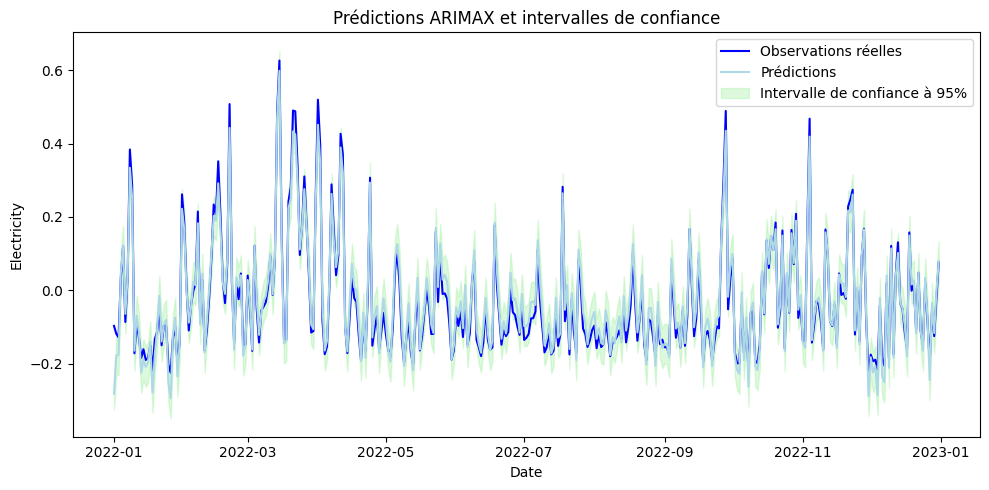

In [41]:
# Prédictions 
predicted_means = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

# Dates de l'ensemble de test - pour l'axe des x
dates = y_test.index

# Tracer les observations réelles
plt.figure(figsize=(10,5))
plt.plot(dates, y_test, label='Observations réelles', color='blue')

# Tracer les prédictions moyennes
plt.plot(dates, predicted_means, label='Prédictions', color='lightblue')

# Tracer les intervalles de confiance
plt.fill_between(dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='lightgreen', alpha=0.3, label='Intervalle de confiance à 95%')

# Personnaliser le graphique
plt.title('Prédictions ARIMAX et intervalles de confiance')
plt.xlabel('Date')
plt.ylabel('Electricity')
plt.legend()
plt.tight_layout()

# Afficher le graphique
plt.show()

### Etude des résidus

In [42]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox


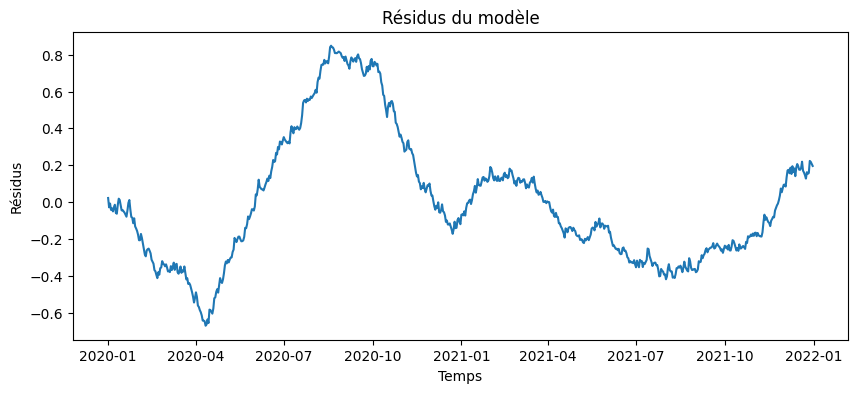

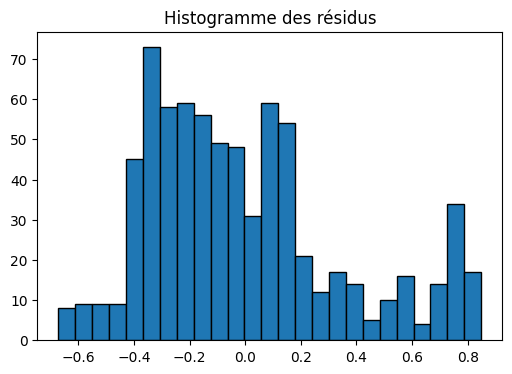

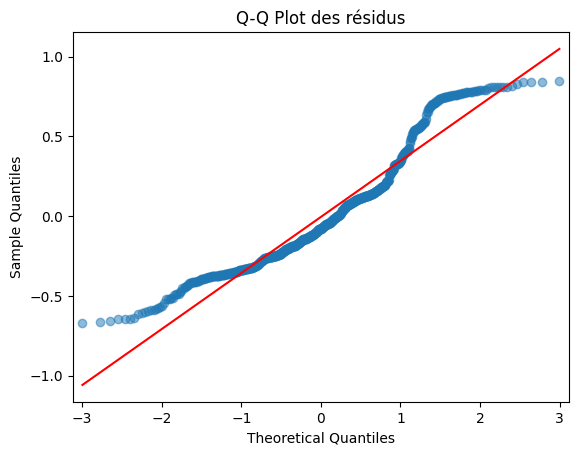

Statistiques de Shapiro-Wilk: 0.9322124123573303
P-value: 1.1010904708978158e-17
        lb_stat  lb_pvalue
10  7151.543664        0.0


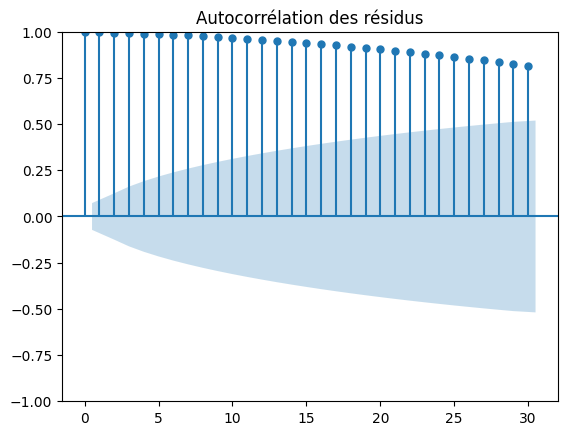

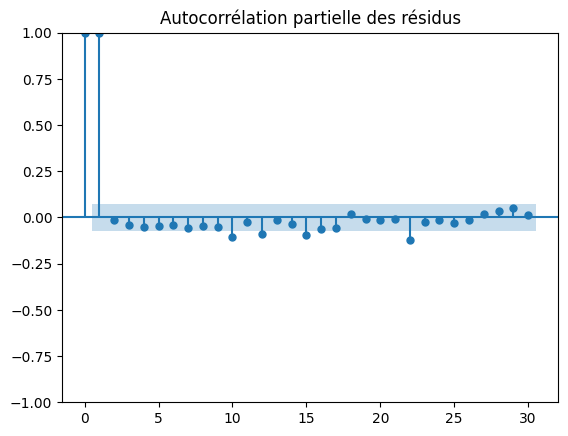

In [43]:
# Obtenir les résidus
residuals = results.resid

# Tracer les résidus
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Résidus du modèle')
plt.ylabel('Résidus')
plt.xlabel('Temps')
plt.show()

# Tracer l'histogramme des résidus
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=25, edgecolor='k')
plt.title('Histogramme des résidus')
plt.show()

# Tracer le Q-Q plot
qqplot(residuals, line='s', alpha=0.5)
plt.title('Q-Q Plot des résidus')
plt.show()

# Effectuer le test de Shapiro-Wilk pour la normalité
stat, p_value = shapiro(residuals)
print('Statistiques de Shapiro-Wilk:', stat)
print('P-value:', p_value)

# Effectuer le test de Ljung-Box sur les résidus pour vérifier l'autocorrélation
# lbvalue, pvalue, _, _ = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=False)
# print('Valeur Ljung-Box:', lbvalue)
# print('P-value Ljung-Box:', pvalue)

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

# Tracer l'Autocorrelation Function (ACF)
sm.graphics.tsa.plot_acf(residuals, lags=30, alpha=0.05)
plt.title('Autocorrélation des résidus')
plt.show()

# Tracer la Partial Autocorrelation Function (PACF)
sm.graphics.tsa.plot_pacf(residuals, lags=30, alpha=0.05, method='ywm')
plt.title('Autocorrélation partielle des résidus')
plt.show()

### Comparaison avec le modèle ARMA

Pour rappel, avec la modélisation ARMA, on avait obtenu le sveleurs des métriques suivantes : 

* MSE: 0.01718373288815149

* MAE: 0.10142474638483692

* RMSE: 0.13108673803307294

* R²: 0.2688179904617741

In [44]:
assert len(predicted_means) == len(y_test), "La longueur des prédictions et des valeurs réelles doit être identique."

# Calculer les métriques
mse = mean_squared_error(y_test, predicted_means)
mae = mean_absolute_error(y_test, predicted_means)
rmse = np.sqrt(mse)  # RMSE est simplement la racine carrée de MSE
r2 = r2_score(y_test, predicted_means)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MSE: 0.0007913146435374964
MAE: 0.02215303484475052
RMSE: 0.028130315382830253
R²: 0.9663289091488542


### Modélisation ARIMAX avec normalisation des variables hexogènes

In [45]:
# Sélectionner les variables exogènes spécifiques et la variable cible
variables_exogenes = ['wind_speed', 'prectotland', 'cldtot', 'swgdn']
df_for_arimax = df_merged_norm[['electricity'] + variables_exogenes]

# Définir la date de coupure entre les données d'entraînement et de test
split_date = pd.Timestamp('2021-12-31')

# Diviser les données en ensembles d'entraînement et de test
train = df_for_arimax.loc[:split_date]
test = df_for_arimax.loc[split_date + pd.Timedelta(days=1):]

# Extraire les variables dépendantes et indépendantes pour l'entraînement et le test
y_train = train['electricity']
X_train = train[variables_exogenes]

y_test = test['electricity']
X_test = test[variables_exogenes]

p = 1
d = 0
q = 3

# Ajustement du modèle ARIMAX avec les variables exogènes choisies
model = sm.tsa.ARIMA(endog=y_train, exog=X_train[variables_exogenes], order=(p, d, q))
results = model.fit()

# Affichage du résumé du modèle
print(results.summary())

# Prédictions avec les variables exogènes
predictions = results.get_forecast(steps=len(y_test), exog=X_test[variables_exogenes])
predicted_means = predictions.predicted_mean
predicted_intervals = predictions.conf_int()

c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

                               SARIMAX Results                                
Dep. Variable:            electricity   No. Observations:                  731
Model:                 ARIMA(1, 0, 3)   Log Likelihood                1412.168
Date:                Mon, 18 Mar 2024   AIC                          -2804.336
Time:                        16:10:46   BIC                          -2758.392
Sample:                    01-01-2020   HQIC                         -2786.611
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5804      0.004   -149.017      0.000      -0.588      -0.573
wind_speed      0.1000      0.001    159.201      0.000       0.099       0.101
prectotland     0.0007      0.001      0.774    

c:\Users\Manon Julia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


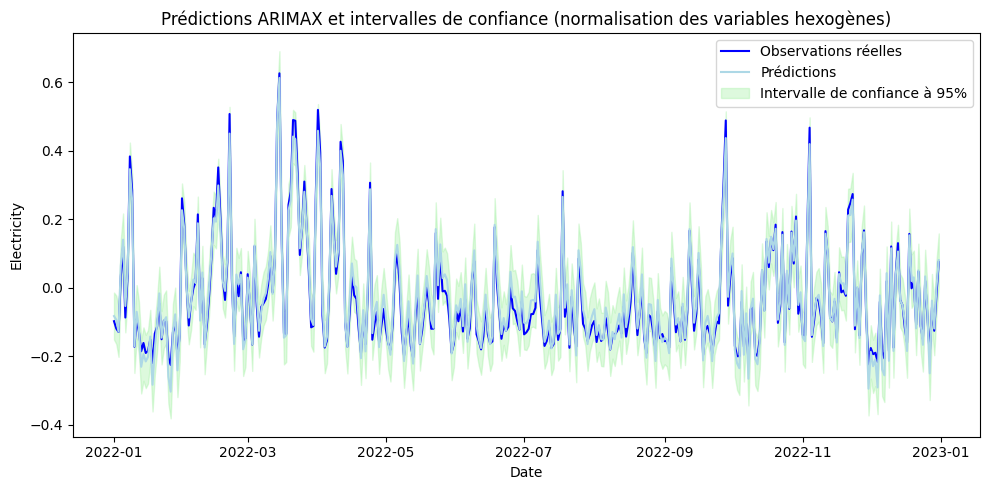

In [48]:
# Prédictions 
predicted_means = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

# Dates de l'ensemble de test - pour l'axe des x
dates = y_test.index

# Tracer les observations réelles
plt.figure(figsize=(10,5))
plt.plot(dates, y_test, label='Observations réelles', color='blue')

# Tracer les prédictions moyennes
plt.plot(dates, predicted_means, label='Prédictions', color='lightblue')

# Tracer les intervalles de confiance
plt.fill_between(dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='lightgreen', alpha=0.3, label='Intervalle de confiance à 95%')

# Personnaliser le graphique
plt.title('Prédictions ARIMAX et intervalles de confiance (normalisation des variables hexogènes)')
plt.xlabel('Date')
plt.ylabel('Electricity')
plt.legend()
plt.tight_layout()

# Afficher le graphique
plt.show()

In [47]:
assert len(predicted_means) == len(y_test), "La longueur des prédictions et des valeurs réelles doit être identique."

# Calculer les métriques
mse = mean_squared_error(y_test, predicted_means)
mae = mean_absolute_error(y_test, predicted_means)
rmse = np.sqrt(mse)  # RMSE est simplement la racine carrée de MSE
r2 = r2_score(y_test, predicted_means)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MSE: 0.0006376867911873008
MAE: 0.02074783226785127
RMSE: 0.025252461091689674
R²: 0.9728659009965284


Rappel des métriques sur le modèle ARIMAX sans normalisation des variables hexogènes

MSE: 0.0007913146435374964

MAE: 0.02215303484475052

RMSE: 0.028130315382830253

R²: 0.9663289091488542